# Examples

In [1]:
import os, sys, time, math, glob, json
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import mdshare
import torch

import models
torch.cuda.is_available()

/home/ev50049/anaconda3/envs/mbemma110/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Data

### Alanine-dipeptide

In [2]:
## first
# data = np.load(mdshare.fetch('alanine-dipeptide-3x250ns-heavy-atom-positions.npz'))["arr_0"]
# ref_data = np.load(mdshare.fetch('alanine-dipeptide-3x250ns-backbone-dihedrals.npz'))["arr_0"]

## if you installed once
data = np.load('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')["arr_0"]
ref_data = np.load('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')["arr_0"]

n_timesteps, input_dim = data.shape

from sklearn import preprocessing
preprocessed_data = preprocessing.StandardScaler().fit_transform(data)

### Chignolin

Our chignolin dataset can be obtained via [this link](https://www.dropbox.com/sh/ag8vflw51ne5htj/AAB-e_o2A6dDZ7ZaqFDSmhOGa?dl=0)

In [4]:
import pyemma

pdb = "prot.pdb"
dcd = "prot5.dcd"
name = dcd.split(".")[0]

feat = pyemma.coordinates.featurizer(pdb)
feat.add_distances_ca()
dist_data = pyemma.coordinates.load(dcd, features=feat)
edist_data = np.exp(-dist_data)
n_timesteps, input_dim = edist_data.shape

from sklearn import decomposition
pca = decomposition.PCA(n_components=input_dim, whiten=True)
preprocessed_data = pca.fit_transform(edist_data)

## Models

In [3]:
m = models.tsTVAE(input_dim, lagtime=1, n_epochs=10, latent_dim=2, print_every=1)
embed = m.fit_transform(preprocessed_data)
embed.shape

Train Epoch: [1/10] main:16.0590 MSELoss:14.5558 KLD Loss:0.0000 KLD Transition Loss:1.5033
Train Epoch: [2/10] main:14.7661 MSELoss:13.3114 KLD Loss:0.0000 KLD Transition Loss:1.4546
Train Epoch: [3/10] main:14.6466 MSELoss:13.2181 KLD Loss:0.0000 KLD Transition Loss:1.4285
Train Epoch: [4/10] main:14.6046 MSELoss:13.1772 KLD Loss:0.0000 KLD Transition Loss:1.4274
Train Epoch: [5/10] main:14.5782 MSELoss:13.1483 KLD Loss:0.0000 KLD Transition Loss:1.4299
Train Epoch: [6/10] main:14.5336 MSELoss:13.1063 KLD Loss:0.0000 KLD Transition Loss:1.4273
Train Epoch: [7/10] main:14.5237 MSELoss:13.0992 KLD Loss:0.0000 KLD Transition Loss:1.4245
Train Epoch: [8/10] main:14.4944 MSELoss:13.0766 KLD Loss:0.0000 KLD Transition Loss:1.4178
Train Epoch: [9/10] main:14.5051 MSELoss:13.0857 KLD Loss:0.0000 KLD Transition Loss:1.4194
Train Epoch: [10/10] main:14.4787 MSELoss:13.0666 KLD Loss:0.0000 KLD Transition Loss:1.4122


(250000, 2)

## MSM Analysis by PyEMMA

In [5]:
import pyemma

n_clusters = 100
stride = 10
fixed_seed = 0
msm_lagtime = 10
n_macrostates = 4

cluster = pyemma.coordinates.cluster_kmeans(embed, k=n_clusters, max_iter=50, stride=stride, fixed_seed=fixed_seed)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=msm_lagtime, dt_traj="1 ps")
msm.pcca(n_macrostates)

100%|██████████| 100/100 [00:09<00:00, 10.84it/s]                            

100%|██████████| 50/50 [00:09<00:00,  5.38it/s]                  
7395it [00:01, 4427.56it/s]                                                                                                           
100%|██████████| 100/100 [00:02<00:00, 35.12it/s]                                                                 


PCCA(P=array([[0.02754, 0.00272, ..., 0.00136, 0.01379],
       [0.00089, 0.05142, ..., 0.0245 , 0.00051],
       ...,
       [0.00088, 0.0482 , ..., 0.02636, 0.00037],
       [0.03089, 0.00349, ..., 0.0013 , 0.01564]]),
   m=4)

Text(0, 0.5, '$z_2$')

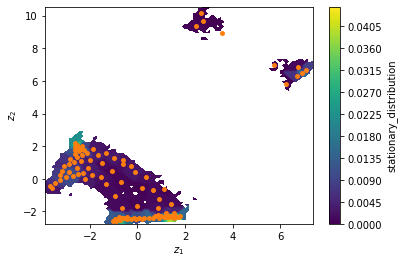

In [6]:
fig, ax, _ = pyemma.plots.plot_contour(*embed[:,:2].T, msm.pi[dtrajs_concatenated], 
                                      cbar_label='stationary_distribution', method='nearest', mask=True)
ax.scatter(*cluster.clustercenters.T, s=15, c='C1')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')

Text(0, 0.5, '$\\psi$')

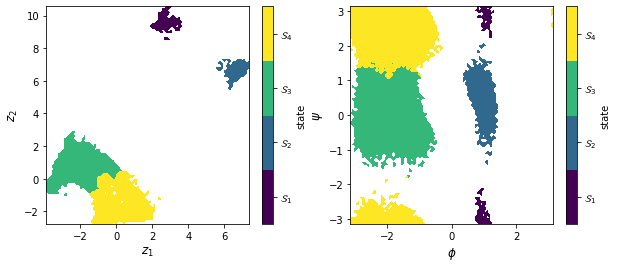

In [7]:
n_states = 4; title_list = ["embed", r"$(\phi,\psi)$"]
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]
fig, ax = plt.subplots(1,2,figsize=(10,4))
fs=12
for i, d in enumerate([embed, ref_data]):
    _, _, misc = pyemma.plots.plot_state_map(*d[:,:2].T, metastable_traj, ax=ax[i])
    misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$'%(k+1) for k in range(n_macrostates)])
ax[0].set_xlabel(r"$z_1$", fontsize=fs)
ax[0].set_ylabel(r"$z_2$", fontsize=fs)
ax[1].set_xlabel(r"$\phi$", fontsize=fs)
ax[1].set_ylabel(r"$\psi$", fontsize=fs)

100%|██████████| 6/6 [00:08<00:00,  1.37s/it]                        


<AxesSubplot:xlabel='lag time / ps', ylabel='timescale / ps'>

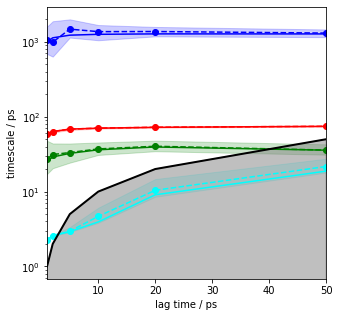

In [8]:
its = pyemma.msm.its(cluster.dtrajs, lags=[1,2,5,10,20,50], nits=n_macrostates, errors='bayes')
fig, ax = plt.subplots(1,1,figsize=(5,5))
pyemma.plots.plot_implied_timescales(its, ax=ax, units='ps')

## MSM Analysis by MSMBuilder

In [5]:
# from msmbuilder.cluster import MiniBatchKMeans
# from msmbuilder.msm import MarkovStateModel

# n_clusters = 100
# clusterer = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
# clustered_trajs = clusterer.fit_transform([embed])

# msm_lagtime = 10
# n_timescales = 3
# msm = MarkovStateModel(lag_time=msm_lagtime, n_timescales=n_timescales)
# msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.10. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=10, n_timescales=3,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

In [6]:
# import msmexplorer as msme

# assignments = clusterer.partial_transform(embed)
# assignments = msm.partial_transform(assignments)
# msme.plot_free_energy(embed, obs=(0, 1), n_samples=10000,
#                       pi=msm.populations_[assignments],
#                       xlabel='z1', ylabel='z2')
# plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
#             clusterer.cluster_centers_[msm.state_labels_, 1],
#             s=1e4 * msm.populations_,       # size by population
#             c=msm.left_eigenvectors_[:, 1], # color by eigenvector
#             cmap="coolwarm",
#             zorder=3) 
# plt.colorbar(label='First dynamical eigenvector')
# plt.tight_layout()

ModuleNotFoundError: No module named 'msmexplorer'